# Example: Synthetic module EL IV
This example shows how to build synthetic module EL IVs using single cell SDM parameters

In [1]:
import os
from pathlib import Path

project_root = Path.cwd().parents[1]
os.chdir(project_root)   # now cwd is .../pvcracks

from pvcracks.pvspice_lite.pvspice_tools import run_ngspice
from pvcracks.pvspice_lite.pvspice_tools import ngpsice_read_voltage_current_modules

from pvcracks.pvspice_lite.pvspice_tools import Create_Cell_NetCode
from pvcracks.pvspice_lite.pvspice_tools import MiniMod_Spice

from pvcracks.pvspice_lite.pvspice_helper import Read_IV
from pvcracks.pvspice_lite.pvspice_helper import Read_EL
from pvcracks.pvspice_lite.pvspice_helper import cells2Mod
from pvcracks.pvspice_lite.pvspice_helper import Extract_Params


import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import pvlib
import scipy

## Install ngspice
Install ngspice with conda:
- conda install ngspice
Find path (e.g. "/home//.conda/envs/pyhpc_spice/bin/ngspice")
Edit the spicepath below to be that path

In [2]:
# spicepath = <your spice path>
spicepath = '/home/bkbyfor/anaconda3/envs/Things/bin/ngspice'
#spicepath = "/home/nrjost/.conda/envs/pyhpc_spice/bin/ngspice"

## Read Data

In [3]:
# Master DataFrame 
Cell9Master = pd.read_csv('docs/data/ELdata_module_209.csv', index_col=0)
# 3x3 minimodule IVs 
FM_Init = Read_IV('docs/data/Minimodule_IVs/209_s0_FM_1000.csv')
FM_Deg1 = Read_IV('docs/data/Minimodule_IVs/209_s1_FM_1000.csv')
FM_Deg2 = Read_IV('docs/data/Minimodule_IVs/209_s2_FM_1000.csv')

In [4]:
Cell9Master.head()

ELPath  Module   Deg        Rs  \
0  /docs/data/EL/209_A3/Init/209_A3_0005_2021_04_...  209_A3  Init  0.008625   
1  /docs/data/EL/209_C1/Init/209_C1_0005_2021_04_...  209_C1  Init  0.009957   
2  /docs/data/EL/209_A2/Init/209_A2_0005_2021_04_...  209_A2  Init  0.008988   
3  /docs/data/EL/209_A1/Init/209_A1_0005_2021_04_...  209_A1  Init  0.009377   
4  /docs/data/EL/209_C2/Init/209_C2_0005_2021_04_...  209_C2  Init  0.009753   

      Rsh         I            Is         N  
0   525.0  8.242323  6.545686e-08  1.292650  
1  1543.5  8.201203  3.488834e-08  1.267408  
2  1380.5  8.223689  6.476966e-08  1.293979  
3  1789.5  8.185086  3.607070e-08  1.254117  
4  1723.0  8.122330  2.261230e-08  1.224717

Cell9Master description
 
    ElPath : Path to the EL image of the cell
    Module : Name of the cell
    Deg    : Degredation step of Mini Module 


SDM params found through fitting of the measured cell IVs
    
    Rs  : Series Resistance 
    Rsh : Shunt Resistance
    I   : Current 
    Is  : Dark Current 
    N   : Diode Ideality Factor


## Display Single Cell Fits

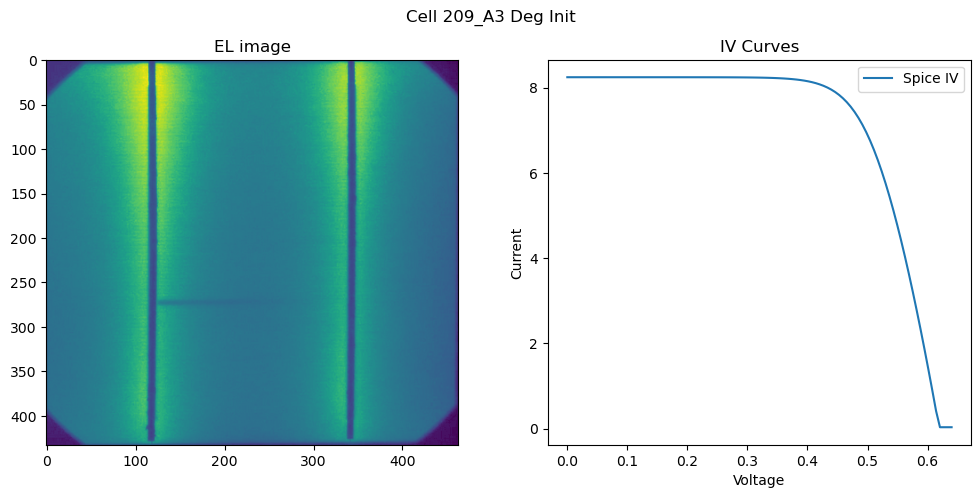

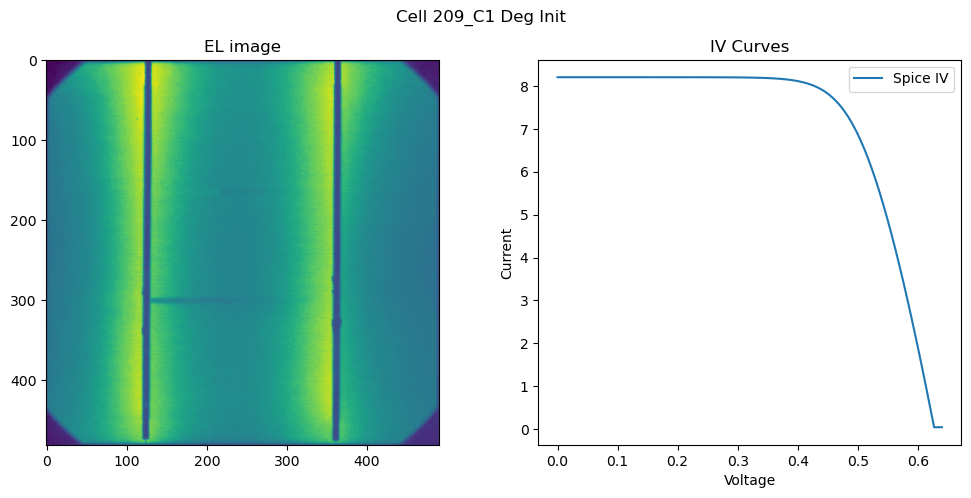

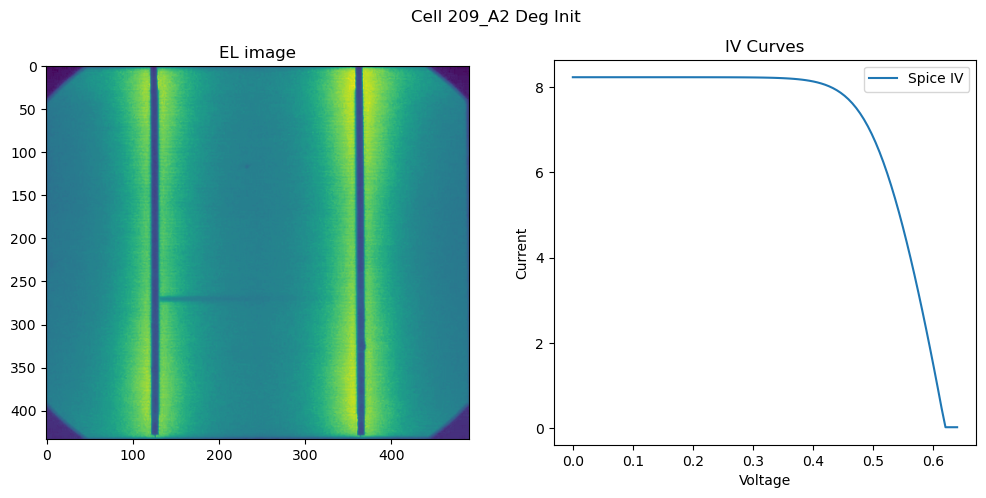

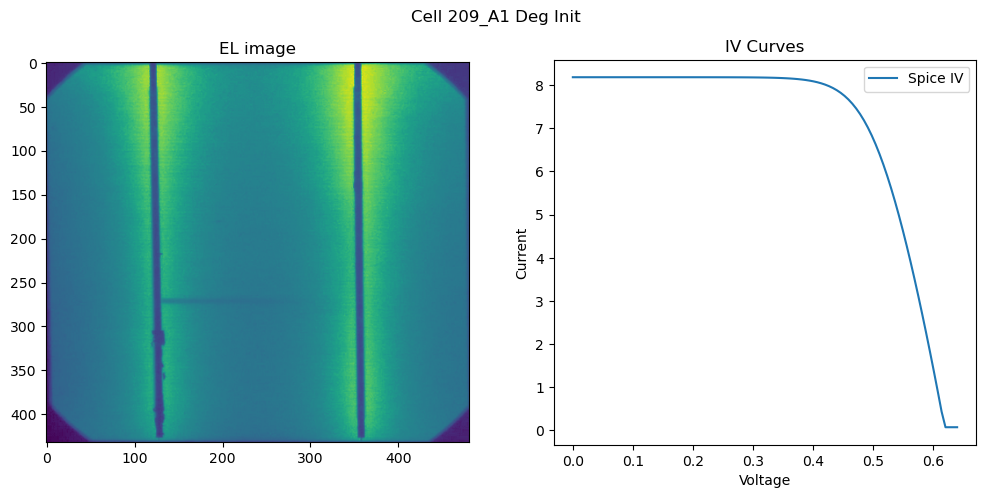

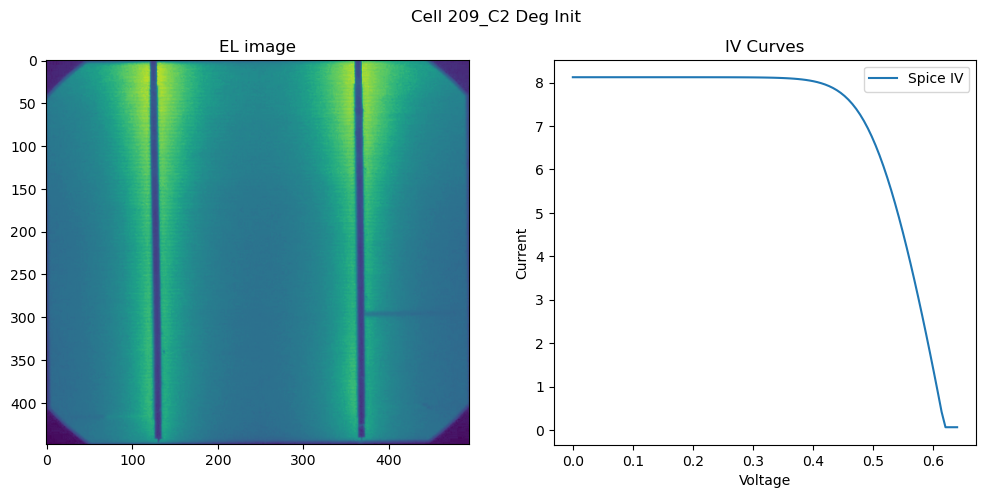

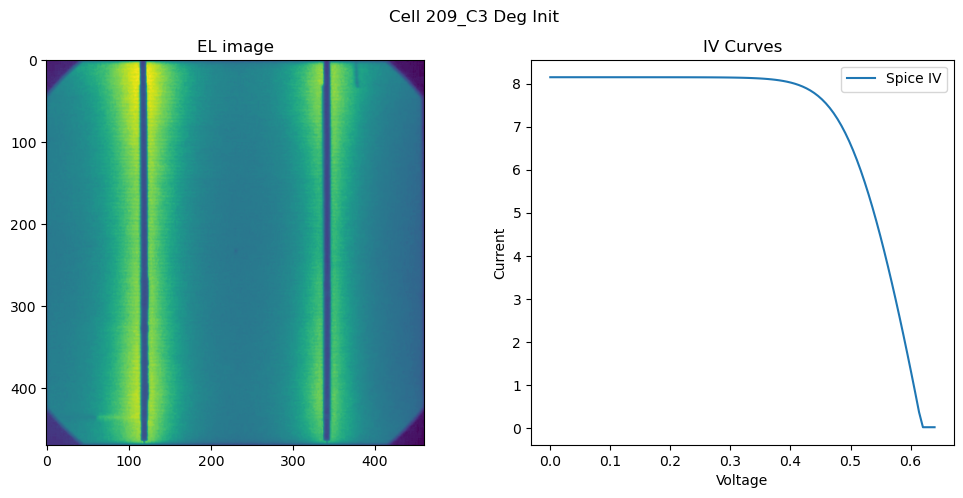

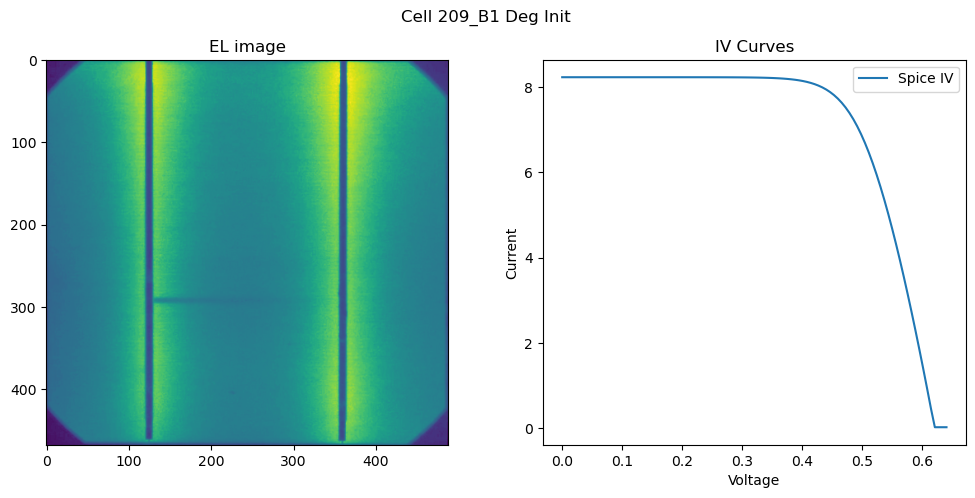

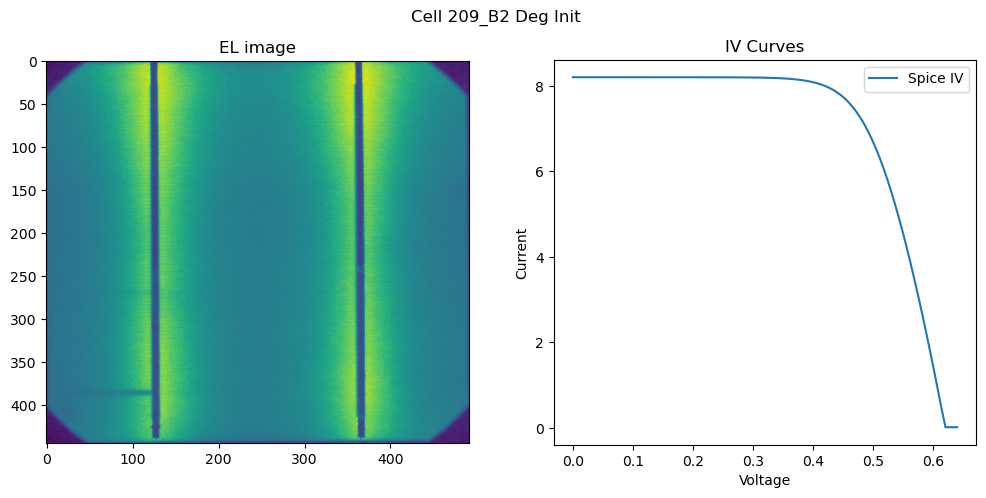

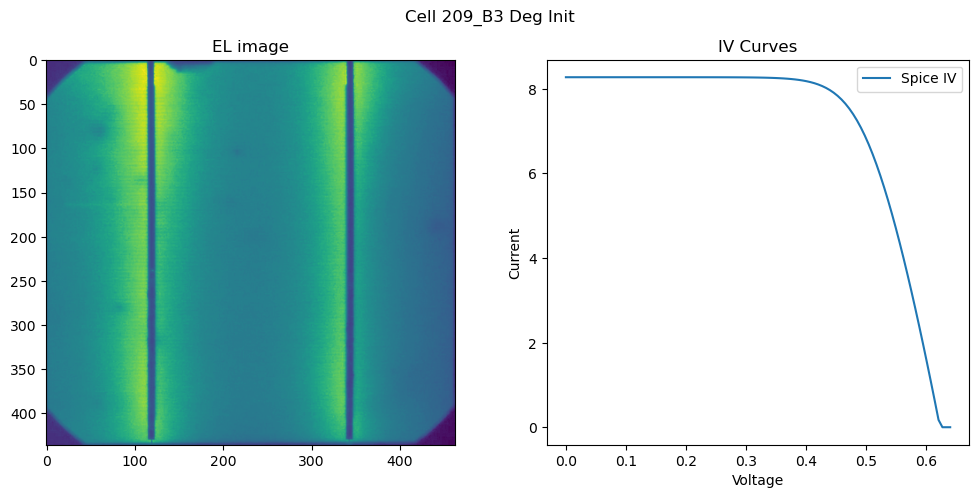

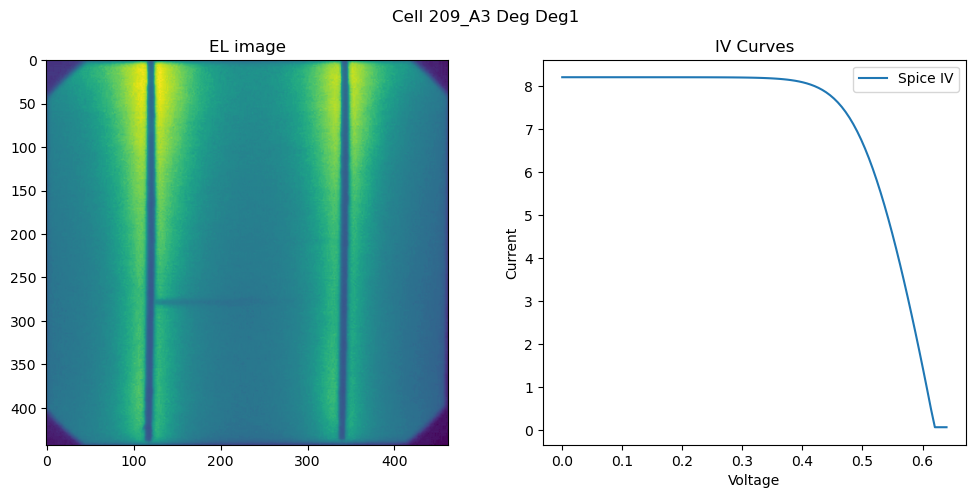

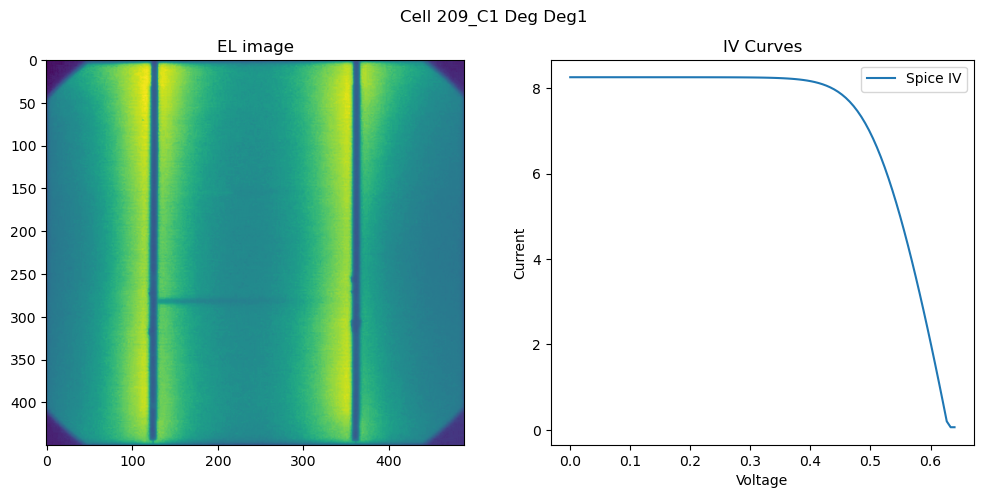

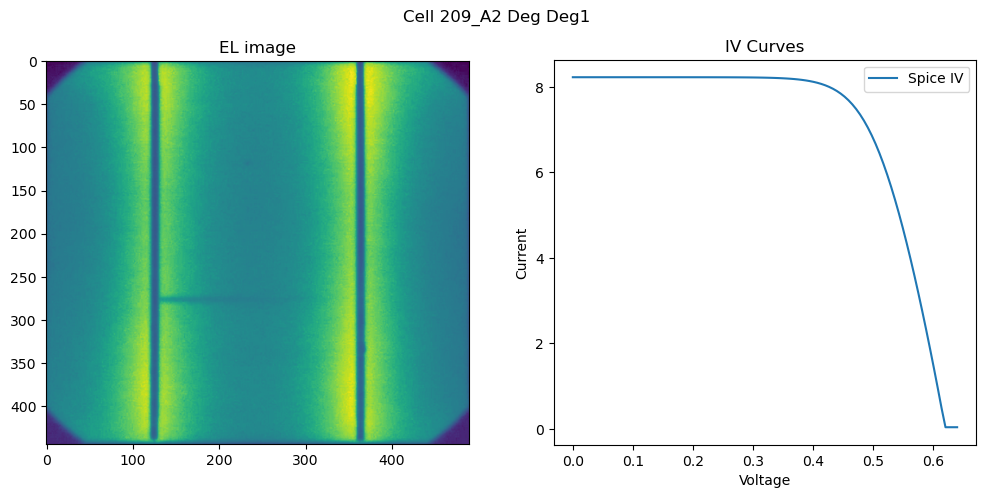

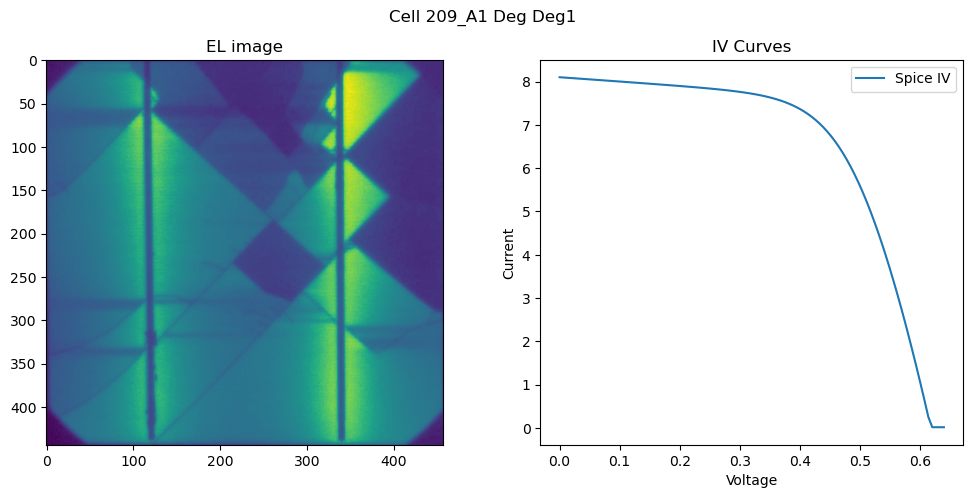

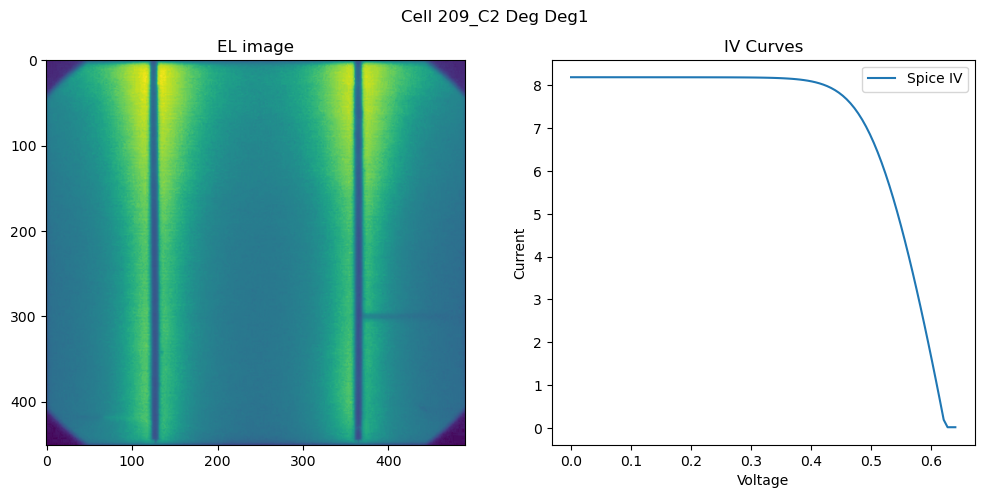

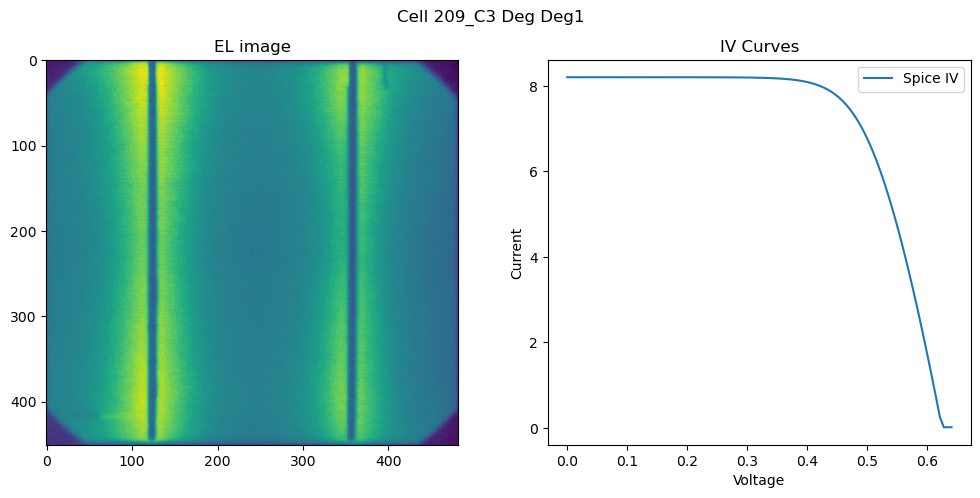

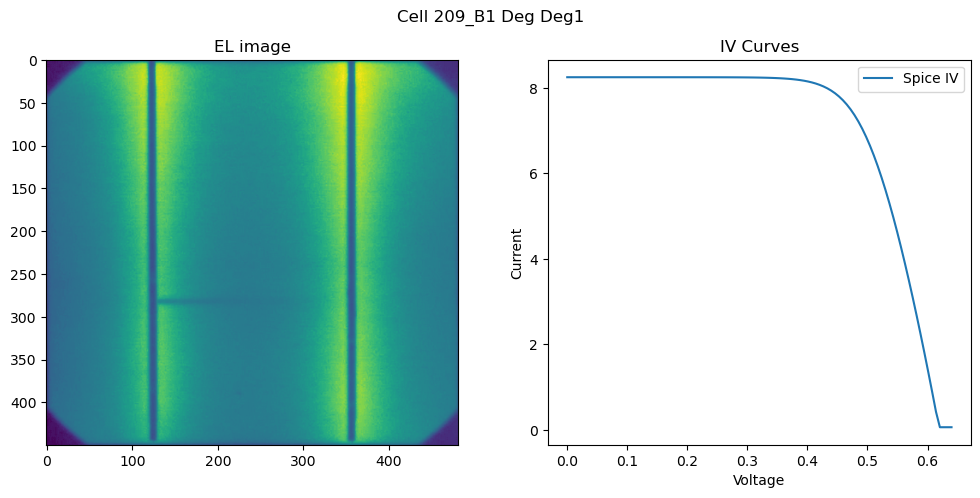

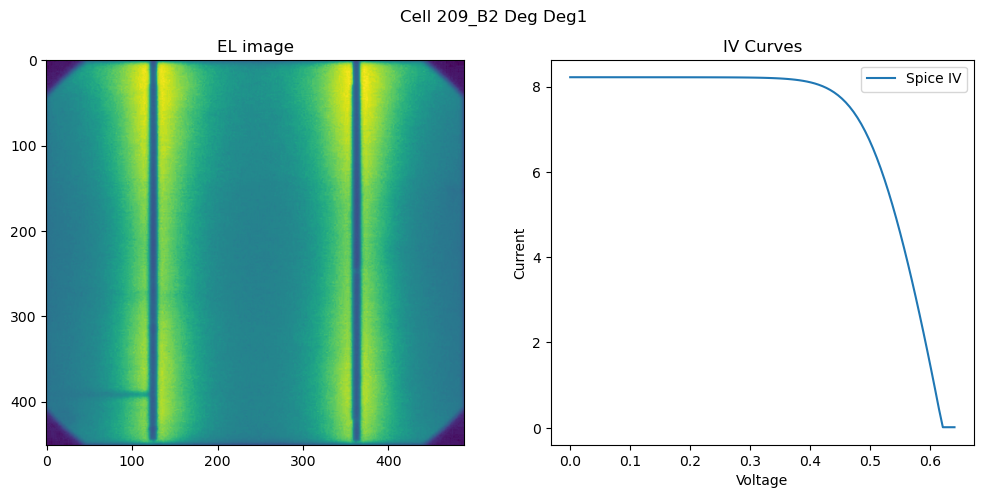

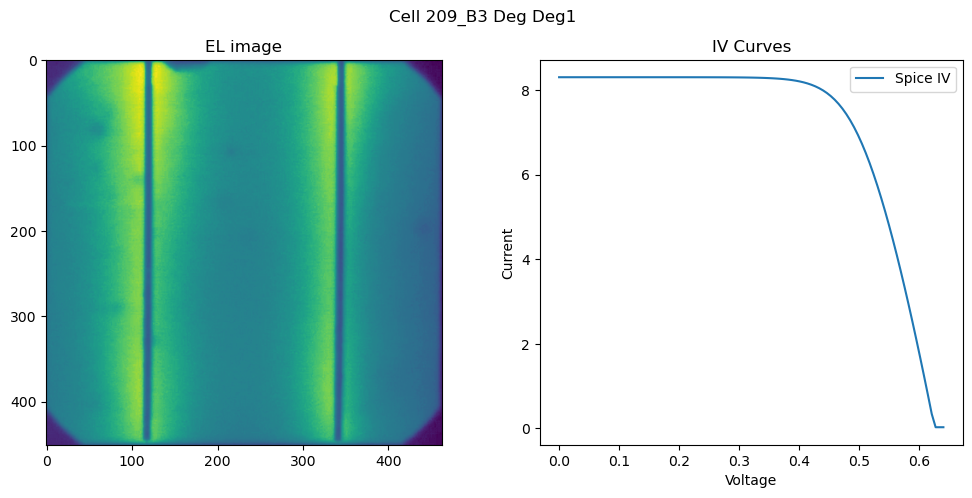

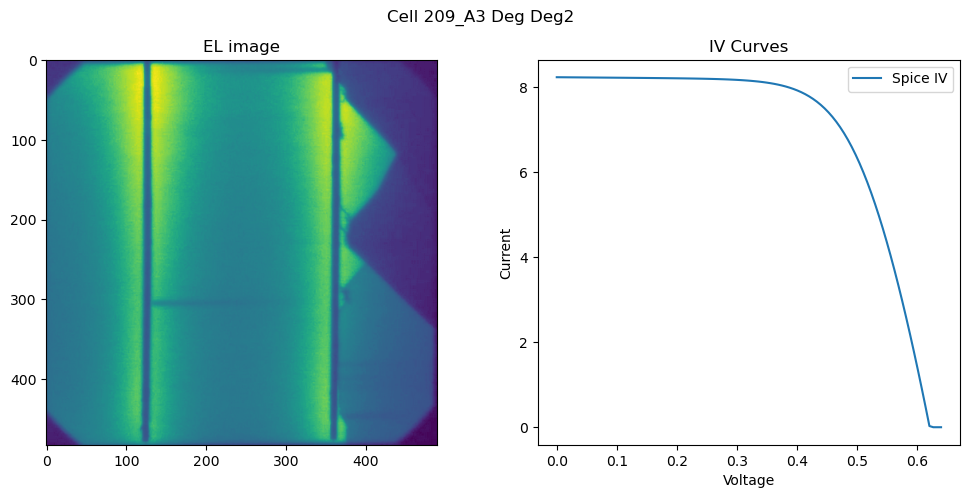

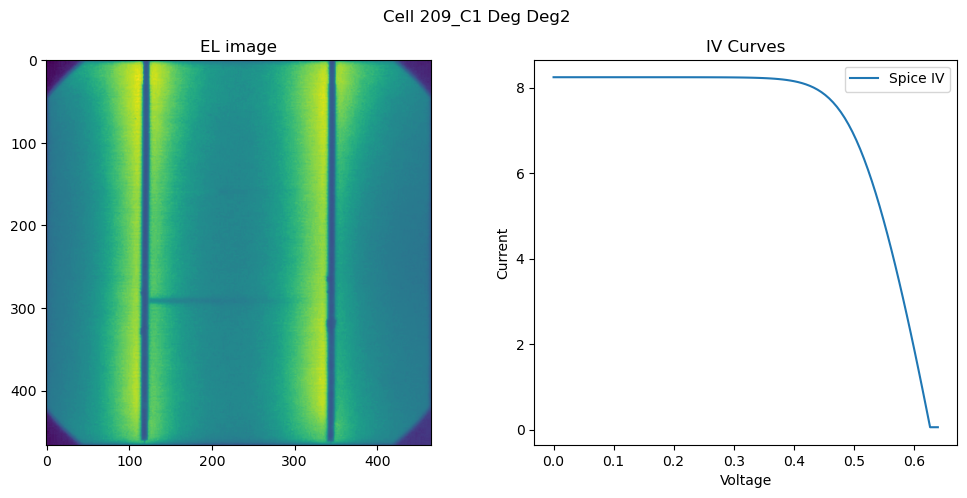

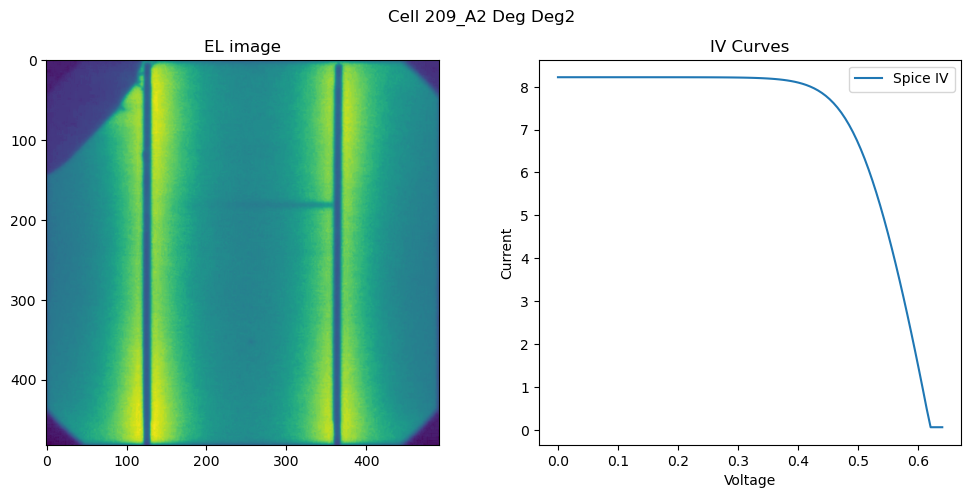

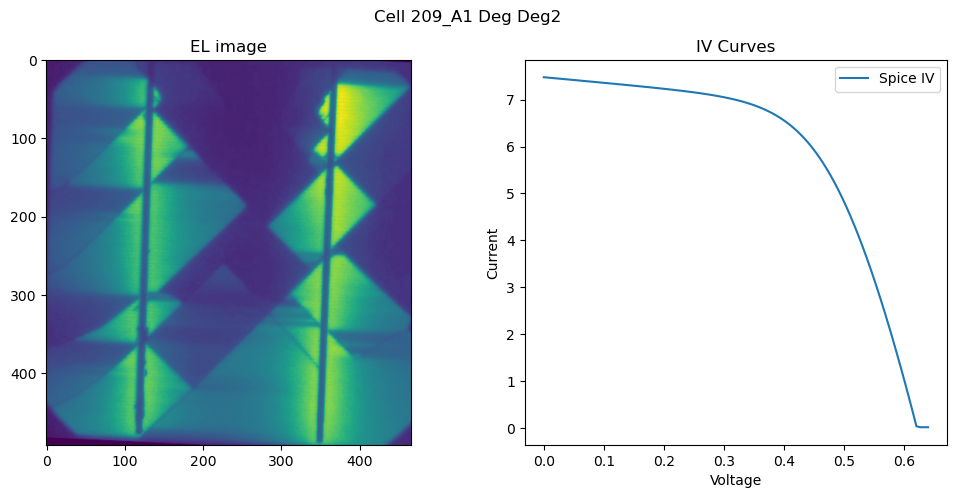

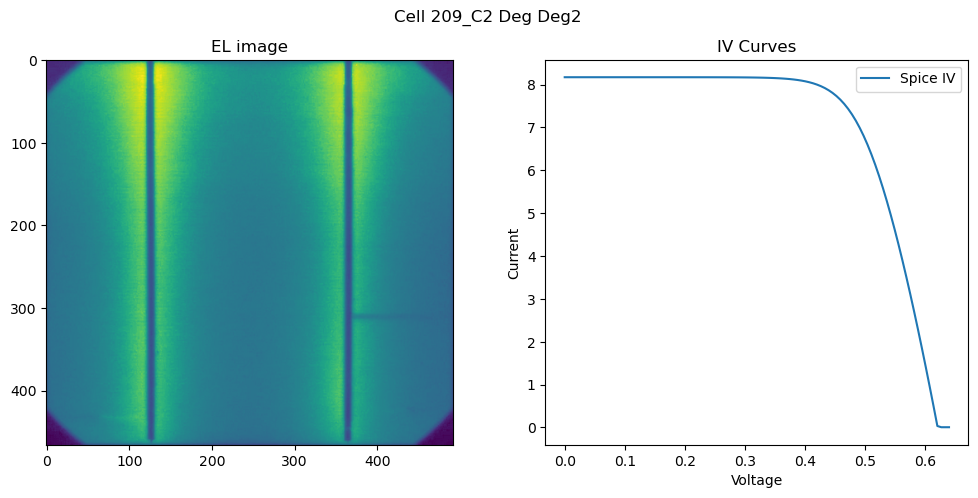

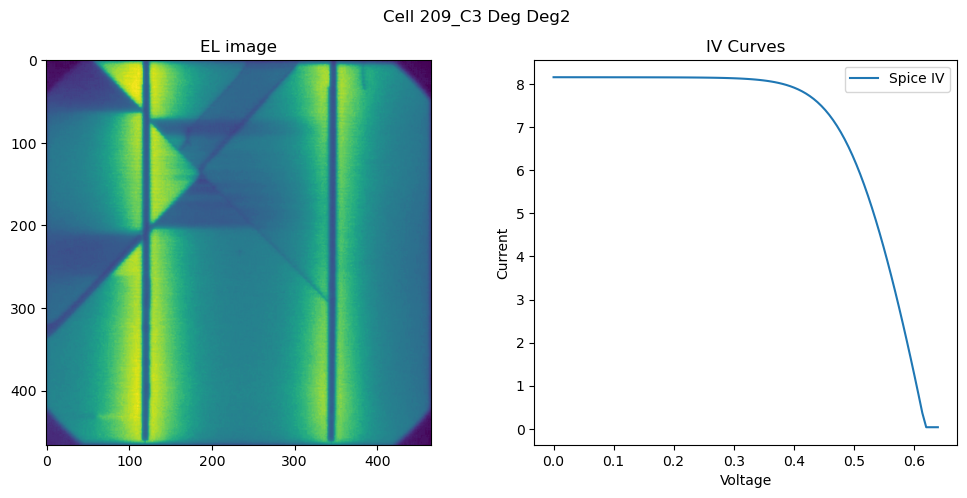

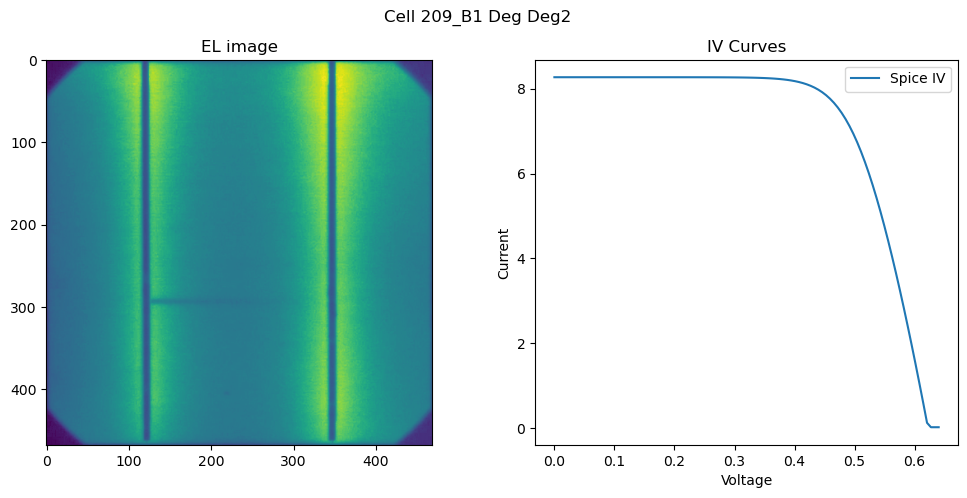

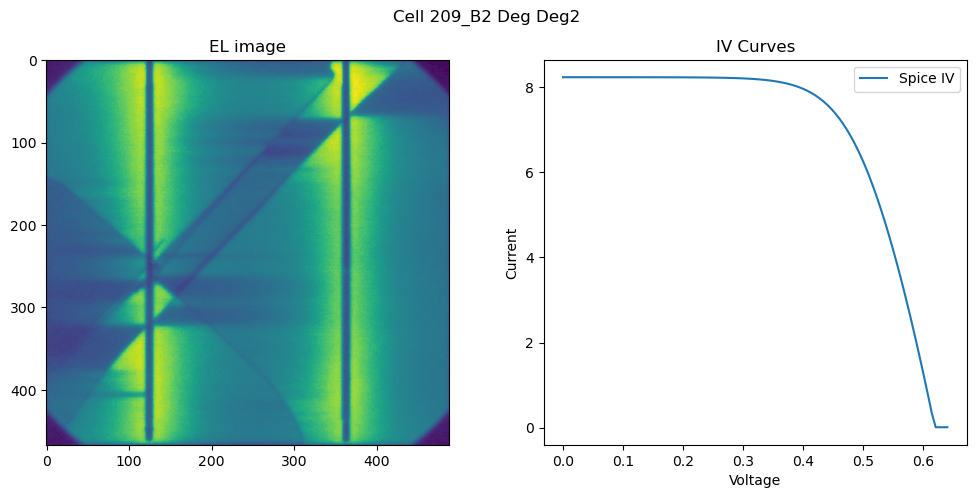

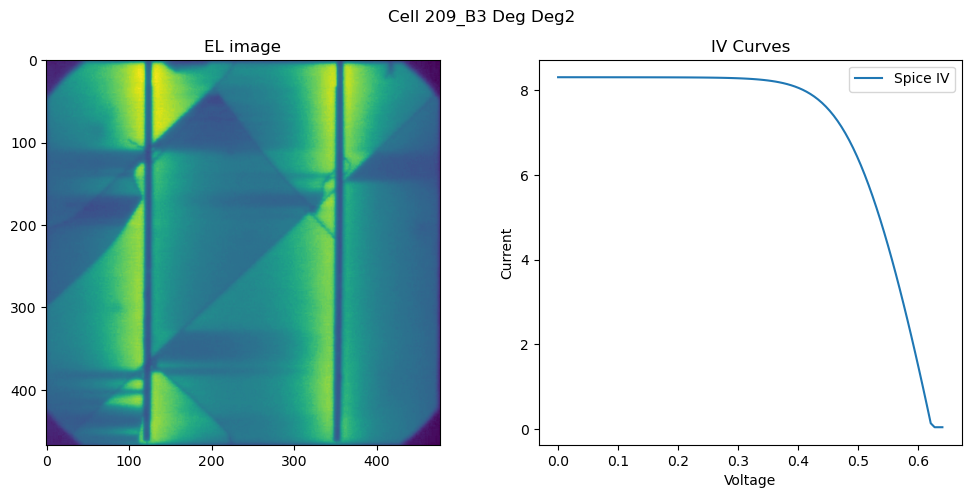

In [5]:
# iterate over the dataframe to display each entry
for ind, row in Cell9Master.iterrows():
    # File Path for writing Spice files 
    file_path = f"{os.getcwd()}/pvcracks/pvspice_lite/"
    # Read image 
    img = Read_EL(f"{os.getcwd()}{row.ELPath}")
    # Order SDM params in the passed DataFrame into a list of dictionary for MiniMod_Spice
    Params =  Extract_Params(Cell9Master.loc[ind:ind])
    # Voltage points for Spice simulation 
    V = np.linspace(0, 0.64, 100) 
    # Spice simulation for series connected SDM cells
    IV_Pred = MiniMod_Spice(Params, file_path, V, V_Step=0.001, file_name ='', spicepath=spicepath)

    # Plot Findings
    fig, axs = plt.subplots(1, 2, figsize = (12,5))
    fig.suptitle(f'Cell {row.Module} Deg {row.Deg}')
    axs[0].imshow(img)
    axs[0].set_title('EL image')
    axs[1].plot(IV_Pred[0], IV_Pred[1], label = 'Spice IV')
    axs[1].set_xlabel('Voltage')
    axs[1].set_ylabel('Current')
    axs[1].set_title('IV Curves')
    axs[1].legend()
    
    plt.show()

# Simulate 3x3 MiniMod

## Initial

In [6]:
# query the slice of initial readings sorted by the Module name 
Init_Cells = Cell9Master.loc[Cell9Master.Deg == 'Init'].sort_values(by=['Module'])

Text(0.5, 0, 'Sample')

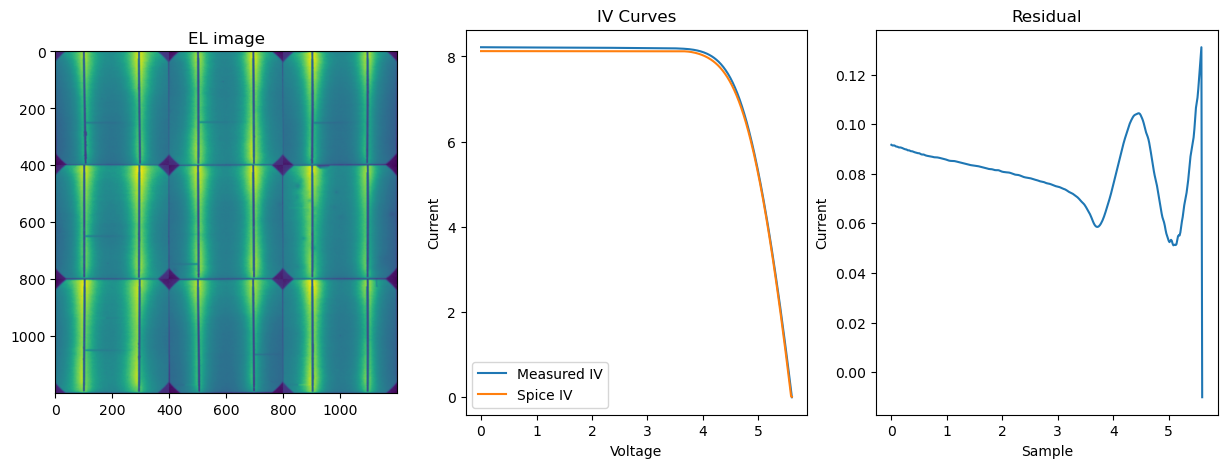

In [7]:
# File Path for writing Spice files 
file_path = f"{os.getcwd()}/pvcracks/pvspice_lite/"
# Construct Image for cells into module 
MMEL = cells2Mod(Init_Cells,(400,400),3,3)
# Order SDM params in the passed DataFrame into a list of dictionary for MiniMod_Spice
Params = Extract_Params(Init_Cells)
# Spice simulation for series connected SDM cells
IV_Pred =  MiniMod_Spice(Params, file_path, FM_Init[0], V_Step=0.001, file_name ='', spicepath=spicepath)

# Plot Findigs 
fig, axs = plt.subplots(1, 3, figsize = (15,5))
axs[0].imshow(MMEL)
axs[0].set_title('EL image')
axs[1].plot(FM_Init[0],FM_Init[1],label = 'Measured IV')
axs[1].plot(IV_Pred[0],IV_Pred[1],label = 'Spice IV')
axs[1].set_xlabel('Voltage')
axs[1].set_ylabel('Current')
axs[1].set_title('IV Curves')
axs[1].legend()
axs[2].set_title('Residual')
axs[2].plot(FM_Init[0],FM_Init[1] - IV_Pred[1])
axs[2].set_ylabel('Current')
axs[2].set_xlabel('Sample')

## Deg1 

In [8]:
# query the slice of Deg 1 readings sorted by the Module name 
Deg1_Cells = Cell9Master.loc[Cell9Master.Deg == 'Deg1'].sort_values(by=['Module'])

Text(0.5, 0, 'Sample')

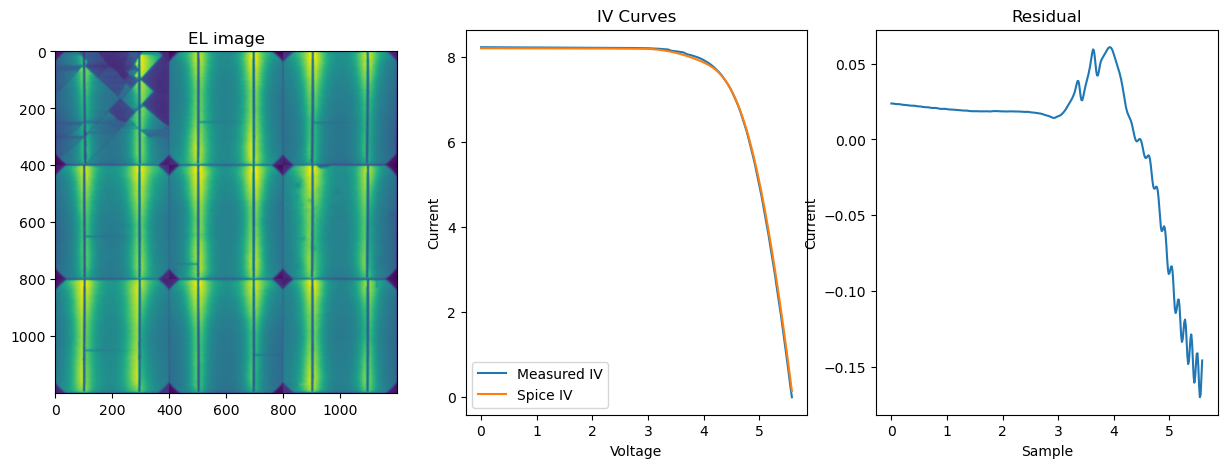

In [9]:
# File Path for writing Spice files 
file_path = f"{os.getcwd()}/pvcracks/pvspice_lite/"
# Construct Image for cells into module 
MMEL = cells2Mod(Deg1_Cells,(400,400),3,3)
# Order SDM params in the passed DataFrame into a list of dictionary for MiniMod_Spice
Params = Extract_Params(Deg1_Cells)
# Spice simulation for series connected SDM cells
IV_Pred =  MiniMod_Spice(Params, file_path, FM_Deg1[0], V_Step=0.001, file_name ='', spicepath=spicepath)

# Plot Findigs 
fig, axs = plt.subplots(1, 3, figsize = (15,5))
axs[0].imshow(MMEL)
axs[0].set_title('EL image')
axs[1].plot(FM_Deg1[0],FM_Deg1[1],label = 'Measured IV')
axs[1].plot(IV_Pred[0],IV_Pred[1],label = 'Spice IV')
axs[1].set_xlabel('Voltage')
axs[1].set_ylabel('Current')
axs[1].set_title('IV Curves')
axs[1].legend()
axs[2].set_title('Residual')
axs[2].plot(FM_Deg1[0],FM_Deg1[1] - IV_Pred[1])
axs[2].set_ylabel('Current')
axs[2].set_xlabel('Sample')

## Deg 2

In [10]:
# query the slice of Deg 2 readings sorted by the Module name 
Deg2_Cells = Cell9Master.loc[Cell9Master.Deg == 'Deg2'].sort_values(by=['Module'])

Text(0.5, 0, 'Sample')

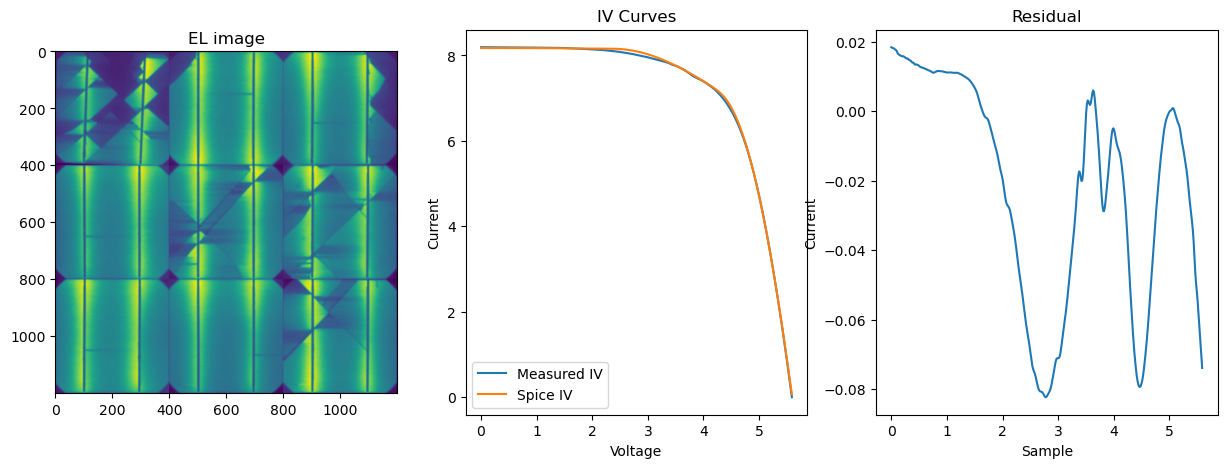

In [11]:
# File Path for writing Spice files 
file_path = f"{os.getcwd()}/pvcracks/pvspice_lite/"
# Construct Image for cells into module 
MMEL = cells2Mod(Deg2_Cells,(400,400),3,3)
# Order SDM params in the passed DataFrame into a list of dictionary for MiniMod_Spice
Params = Extract_Params(Deg2_Cells)
# Spice simulation for series connected SDM cells
IV_Pred =  MiniMod_Spice(Params, file_path, FM_Deg1[0], V_Step=0.001, file_name ='', spicepath=spicepath)

# Plot Findigs 
fig, axs = plt.subplots(1, 3, figsize = (15,5))
axs[0].imshow(MMEL)
axs[0].set_title('EL image')
axs[1].plot(FM_Deg2[0],FM_Deg2[1],label = 'Measured IV')
axs[1].plot(IV_Pred[0],IV_Pred[1],label = 'Spice IV')
axs[1].set_xlabel('Voltage')
axs[1].set_ylabel('Current')
axs[1].set_title('IV Curves')
axs[1].legend()
axs[2].set_title('Residual')
axs[2].plot(FM_Deg2[0],FM_Deg2[1] - IV_Pred[1])
axs[2].set_ylabel('Current')
axs[2].set_xlabel('Sample')

# Constructing Synthetic MiniModule Data 

In [12]:
# Randomly select 4 init cells and combine them into a single dataframe
Synth_MiniMod_Init = Init_Cells.sample(n=4)
# Select the damaged cell (top left corner) in Deg1 and repeat it 4 times
Synth_MiniMod_Deg1 = Deg1_Cells.loc[[12,12,12,12]]
# Select the damaged cell (top left corner) in Deg2 and repeat it 4 times
Synth_MiniMod_Deg2 = Deg2_Cells.loc[[21,21,21,21]]
# Mix 2 initial cells and the most damaged cell in Deg2 
Synth_MiniMod_Mix =  pd.concat((Deg2_Cells.loc[[21,21]],Init_Cells.sample(n=2) ) )

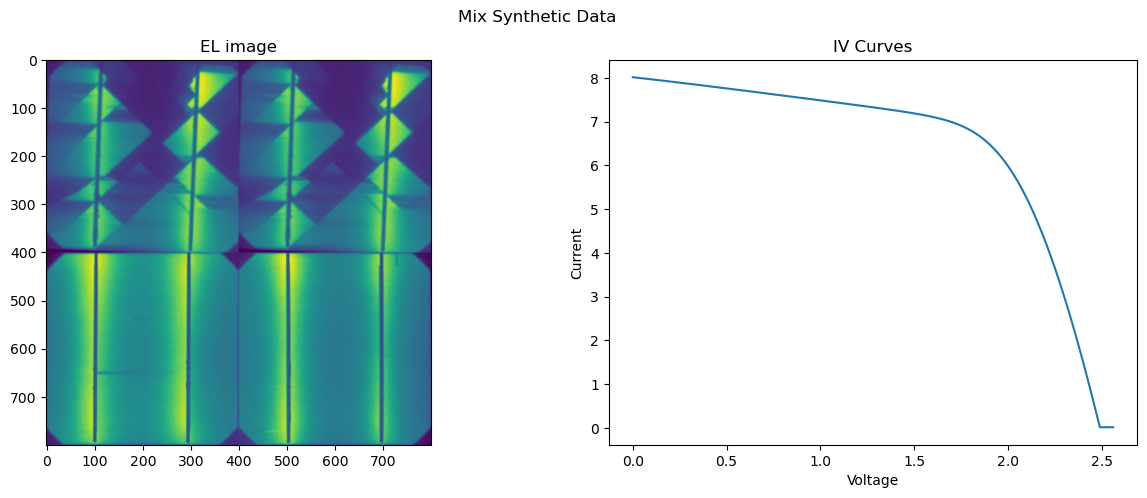

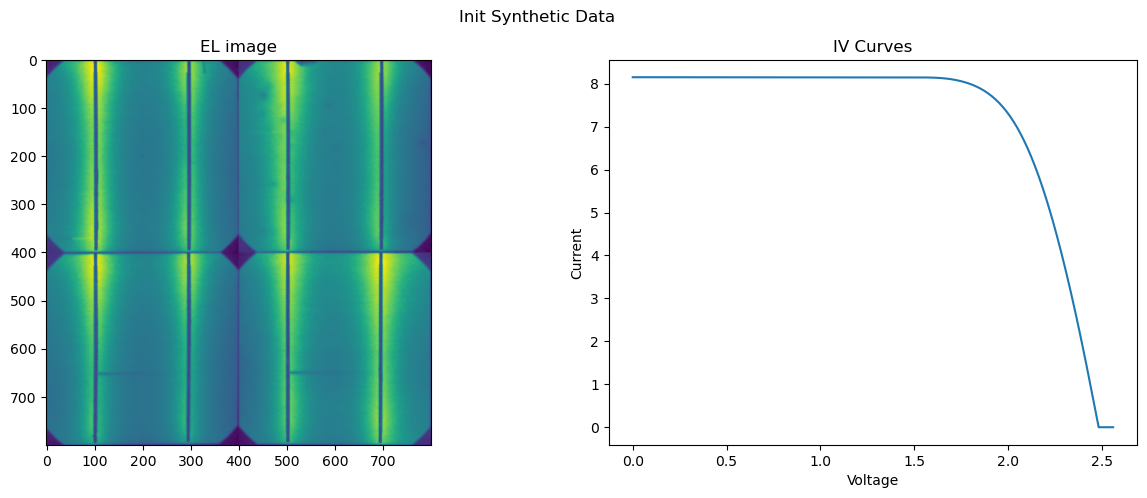

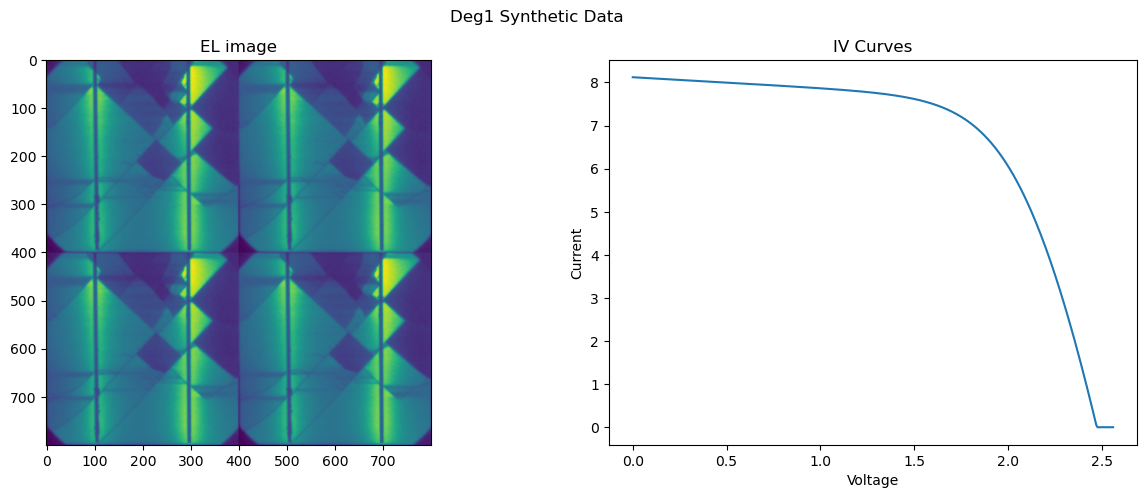

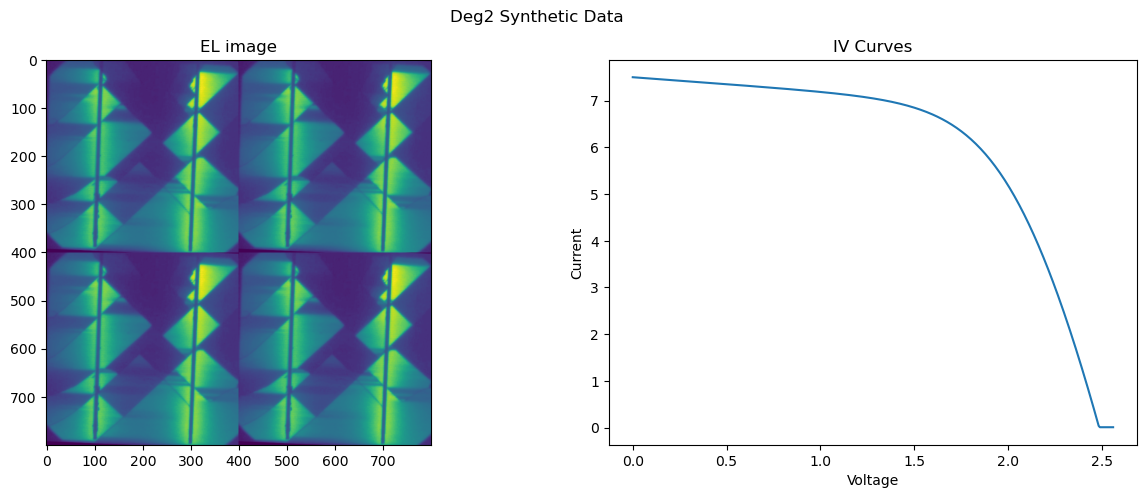

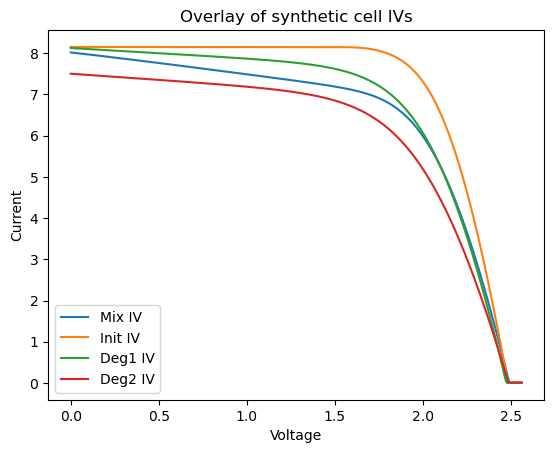

In [13]:
# File Path for writing Spice files 
file_path = f"{os.getcwd()}/pvcracks/pvspice_lite/"
# Voltage over which to simulate
V = np.linspace(0, 0.64*4, 400) 



# Construct Image for cells into module 
MMEL_Mix = cells2Mod(Synth_MiniMod_Mix,(400,400),2,2)
# Order SDM params in the passed DataFrame into a list of dictionary for MiniMod_Spice
Params = Extract_Params(Synth_MiniMod_Mix)
# Spice simulation for series connected SDM cells
IV_Pred_Mix =  MiniMod_Spice(Params, file_path, V, V_Step=0.001, file_name ='', spicepath=spicepath)



# Construct Image for cells into module 
MMEL_Init = cells2Mod(Synth_MiniMod_Init,(400,400),2,2)
# Order SDM params in the passed DataFrame into a list of dictionary for MiniMod_Spice
Params = Extract_Params(Synth_MiniMod_Init)
# Spice simulation for series connected SDM cells
IV_Pred_Init =  MiniMod_Spice(Params, file_path, V, V_Step=0.001, file_name ='', spicepath=spicepath)



# Construct Image for cells into module 
MMEL_Deg1 = cells2Mod(Synth_MiniMod_Deg1,(400,400),2,2)
# Order SDM params in the passed DataFrame into a list of dictionary for MiniMod_Spice
Params = Extract_Params(Synth_MiniMod_Deg1)
# Spice simulation for series connected SDM cells
IV_Pred_Deg1 =  MiniMod_Spice(Params, file_path, V, V_Step=0.001, file_name ='', spicepath=spicepath)



# Construct Image for cells into module 
MMEL_Deg2 = cells2Mod(Synth_MiniMod_Deg2,(400,400),2,2)
# Order SDM params in the passed DataFrame into a list of dictionary for MiniMod_Spice
Params = Extract_Params(Synth_MiniMod_Deg2)
# Spice simulation for series connected SDM cells
IV_Pred_Deg2 =  MiniMod_Spice(Params, file_path, V, V_Step=0.001, file_name ='', spicepath=spicepath)


# Plot Findings 
fig, axs = plt.subplots(1, 2, figsize = (15,5))
fig.suptitle("Mix Synthetic Data")
axs[0].imshow(MMEL_Mix)
axs[0].set_title('EL image')
axs[1].plot(IV_Pred_Mix[0],IV_Pred_Mix[1],label = 'Mix IV')
axs[1].set_xlabel('Voltage')
axs[1].set_ylabel('Current')
axs[1].set_title('IV Curves')

fig, axs = plt.subplots(1, 2, figsize = (15,5))
fig.suptitle("Init Synthetic Data")
axs[0].imshow(MMEL_Init)
axs[0].set_title('EL image')
axs[1].plot(IV_Pred_Init[0],IV_Pred_Init[1],label = 'Init IV')
axs[1].set_xlabel('Voltage')
axs[1].set_ylabel('Current')
axs[1].set_title('IV Curves')

fig, axs = plt.subplots(1, 2, figsize = (15,5))
fig.suptitle("Deg1 Synthetic Data")
axs[0].imshow(MMEL_Deg1)
axs[0].set_title('EL image')
axs[1].plot(IV_Pred_Deg1[0],IV_Pred_Deg1[1],label = 'Deg1 IV')
axs[1].set_xlabel('Voltage')
axs[1].set_ylabel('Current')
axs[1].set_title('IV Curves')

fig, axs = plt.subplots(1, 2, figsize = (15,5))
fig.suptitle("Deg2 Synthetic Data")
axs[0].imshow(MMEL_Deg2)
axs[0].set_title('EL image')
axs[1].plot(IV_Pred_Deg2[0],IV_Pred_Deg2[1],label = 'Deg2 IV')
axs[1].set_xlabel('Voltage')
axs[1].set_ylabel('Current')
axs[1].set_title('IV Curves')


plt.figure()
plt.title("Overlay of synthetic cell IVs")
plt.plot(IV_Pred_Mix[0],IV_Pred_Mix[1],label = 'Mix IV')
plt.plot(IV_Pred_Init[0],IV_Pred_Init[1],label = 'Init IV')
plt.plot(IV_Pred_Deg1[0],IV_Pred_Deg1[1],label = 'Deg1 IV')
plt.plot(IV_Pred_Deg2[0],IV_Pred_Deg2[1],label = 'Deg2 IV')
plt.xlabel('Voltage')
plt.ylabel('Current')
plt.legend()

